In [3]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import gc

# 1) 회원정보 파일 경로 리스트
member_paths = [
    "open/train/1.회원정보/201807_train_회원정보.parquet",
    "open/train/1.회원정보/201808_train_회원정보.parquet",
    "open/train/1.회원정보/201809_train_회원정보.parquet",
    "open/train/1.회원정보/201810_train_회원정보.parquet",
    "open/train/1.회원정보/201811_train_회원정보.parquet",
    "open/train/1.회원정보/201812_train_회원정보.parquet",
]

# 2) 회원정보 통합 및 세그먼트 인코딩
df_members = pd.concat([pd.read_parquet(p)[['ID', 'Segment']] for p in member_paths])
le = LabelEncoder()
df_members['Segment_code'] = le.fit_transform(df_members['Segment'])

# 3) 분석에 사용할 파일과 컬럼 (중복되는 컬럼이 있는 경우 병합 전 제거)
file_columns = {
    "open/train/1.회원정보/201807_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201808_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201809_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201810_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201811_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/1.회원정보/201812_train_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/train/3.승인매출정보/201807_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M'
    ],
    "open/train/3.승인매출정보/201808_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M'
    ],
    "open/train/3.승인매출정보/201809_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M'
    ],
    "open/train/3.승인매출정보/201810_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M'
    ],
    "open/train/3.승인매출정보/201811_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M'
    ],
    "open/train/3.승인매출정보/201812_train_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M'
    ],
    "open/train/4.청구입금정보/201812_train_청구정보.parquet": [
        'ID', '청구금액_R6M'
    ],
    "open/train/5.잔액정보/201812_train_잔액정보.parquet": [
        'ID', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M'
    ]
}

# 4) 데이터 병합 (중복 컬럼 제거하며)
data_chunks = []
for path, cols in file_columns.items():
    df = pd.read_parquet(path, columns=cols)
    if data_chunks:
        existing_cols = set().union(*[set(d.columns) for d in data_chunks])
        overlap = [col for col in df.columns if col in existing_cols and col != 'ID']
        df = df.drop(columns=overlap)
    data_chunks.append(df)

data_merged = data_chunks[0]
for df in data_chunks[1:]:
    data_merged = pd.merge(data_merged, df, on='ID', how='inner')

# 5) 회원정보와 병합
full_df = pd.merge(data_merged, df_members[['ID', 'Segment_code']], on='ID', how='inner')

# 6) 결측치 제거
full_df.dropna(subset=['Segment_code'], inplace=True)

# 7) 피처와 타겟 분리
X = full_df.drop(columns=['ID', 'Segment_code'])
y = full_df['Segment_code']

# 8) 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9) 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 10) LightGBM 모델 학습
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train, feature_name=X.columns.tolist())

# 11) 모델 저장
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(model, 'best_model.pkl')

# 12) 평가
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ 전체 테스트 정확도: {acc:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -2.935696
[LightGBM] [Info] Start training from score -1.927375
[LightGBM] [Info] Start training from score -0.222000

✅ 전체 테스트 정확도: 0.8498


In [7]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원래 학습 데이터에서 일부만 나눠 쓰자 (속도 ↑)
X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# 튜닝 목적 함수 정의
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 64),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 120),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_subtrain, y_subtrain)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    return acc


In [11]:
# 튜닝 실행 (빠르게 끝나도록 10회만)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-07-06 18:19:14,351] A new study created in memory with name: no-name-8f9a03fb-f08a-4ec5-be47-1cba2f8c0634


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:19:37,595] Trial 0 finished with value: 0.8606223958333333 and parameters: {'num_leaves': 52, 'max_depth': 5, 'learning_rate': 0.0745419982006996, 'n_estimators': 86, 'subsample': 0.9621112220916097, 'colsample_bytree': 0.8756541451706563}. Best is trial 0 with value: 0.8606223958333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:19:50,896] Trial 1 finished with value: 0.8565182291666666 and parameters: {'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.14333090180410774, 'n_estimators': 68, 'subsample': 0.8686369584517498, 'colsample_bytree': 0.9714910760016927}. Best is trial 0 with value: 0.8606223958333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:20:22,101] Trial 2 finished with value: 0.8584479166666666 and parameters: {'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.0796702477635986, 'n_estimators': 102, 'subsample': 0.9149488605747546, 'colsample_bytree': 0.8692195765824575}. Best is trial 0 with value: 0.8606223958333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:20:47,189] Trial 3 finished with value: 0.8622291666666667 and parameters: {'num_leaves': 59, 'max_depth': 5, 'learning_rate': 0.11003889706588832, 'n_estimators': 94, 'subsample': 0.8693810577409357, 'colsample_bytree': 0.9191182318969053}. Best is trial 3 with value: 0.8622291666666667.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:21:20,141] Trial 4 finished with value: 0.8611875 and parameters: {'num_leaves': 24, 'max_depth': 8, 'learning_rate': 0.082028027663414, 'n_estimators': 117, 'subsample': 0.91273077974925, 'colsample_bytree': 0.8692730493685302}. Best is trial 3 with value: 0.8622291666666667.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:21:42,187] Trial 5 finished with value: 0.837015625 and parameters: {'num_leaves': 28, 'max_depth': 4, 'learning_rate': 0.10818026914165689, 'n_estimators': 91, 'subsample': 0.9209903286789063, 'colsample_bytree': 0.9689229688095233}. Best is trial 3 with value: 0.8622291666666667.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-07-06 18:22:00,022] Trial 6 finished with value: 0.7942760416666667 and parameters: {'num_leaves': 27, 'max_depth': 9, 'learning_rate': 0.10707646897445802, 'n_estimators': 58, 'subsample': 0.9068308839765515, 'colsample_bytree': 0.9546412716903884}. Best is trial 3 with value: 0.8622291666666667.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:22:38,287] Trial 7 finished with value: 0.8676276041666666 and parameters: {'num_leaves': 63, 'max_depth': 7, 'learning_rate': 0.12661842340412166, 'n_estimators': 108, 'subsample': 0.8171595218801491, 'colsample_bytree': 0.8623028568988492}. Best is trial 7 with value: 0.8676276041666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:23:01,988] Trial 8 finished with value: 0.863125 and parameters: {'num_leaves': 31, 'max_depth': 7, 'learning_rate': 0.14616030486616433, 'n_estimators': 83, 'subsample': 0.8073077579399482, 'colsample_bytree': 0.9049829892843395}. Best is trial 7 with value: 0.8676276041666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-06 18:23:26,093] Trial 9 finished with value: 0.8600833333333333 and parameters: {'num_leaves': 41, 'max_depth': 4, 'learning_rate': 0.07165025029802548, 'n_estimators': 109, 'subsample': 0.8758124798543458, 'colsample_bytree': 0.8450664370770108}. Best is trial 7 with value: 0.8676276041666666.


In [13]:
# 결과 출력
print("\n✅ Best Accuracy from tuning:", study.best_value)
print("✅ Best Parameters:", study.best_params)


✅ Best Accuracy from tuning: 0.8676276041666666
✅ Best Parameters: {'num_leaves': 63, 'max_depth': 7, 'learning_rate': 0.12661842340412166, 'n_estimators': 108, 'subsample': 0.8171595218801491, 'colsample_bytree': 0.8623028568988492}


In [15]:
# 최적 파라미터로 전체 학습/평가
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)
print(f"🎯 최적 모델 최종 테스트 정확도: {final_acc:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 13
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -2.935696
[LightGBM] [Info] Start training from score -1.927375
[LightGBM] [Info] Start training from score -0.222000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


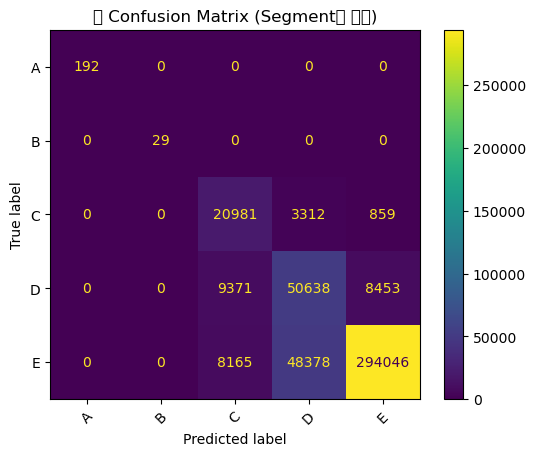

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("🎯 Confusion Matrix (Segment별 예측)")
plt.show()

In [21]:
# 🔒 최적 모델과 스케일러 저장
joblib.dump(best_model, 'best_model_optuna.pkl')
joblib.dump(scaler, 'scaler.pkl')  # 이미 위에서 저장했지만 덮어써도 무방
print("\n💾 최적 모델과 스케일러 저장 완료!")


💾 최적 모델과 스케일러 저장 완료!


In [23]:
import pandas as pd
import joblib

# 1. 경로 정의
test_paths = {
    "open/test/1.회원정보/201812_test_회원정보.parquet": [
        'ID', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '_1순위카드이용금액'
    ],
    "open/test/3.승인매출정보/201812_test_승인매출정보.parquet": [
        'ID', '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_오프라인_B0M',
        '정상입금원금_B0M', '정상입금원금_B2M', '최대이용금액_일시불_R12M'
    ],
    "open/test/4.청구입금정보/201812_test_청구정보.parquet": [
        'ID', '청구금액_R6M'
    ],
    "open/test/5.잔액정보/201812_test_잔액정보.parquet": [
        'ID', '평잔_일시불_6M', '월중평잔_일시불_B0M', '잔액_할부_B0M'
    ]
}

# 2. 파일 읽고 병합
test_chunks = []
for path, cols in test_paths.items():
    df = pd.read_parquet(path, columns=cols)
    test_chunks.append(df)

test_df = test_chunks[0]
for df in test_chunks[1:]:
    test_df = pd.merge(test_df, df, on='ID', how='inner')

# 3. ID 따로 저장해두기 (나중에 예측값 붙이기 위함)
test_ids = test_df['ID']
X_test_data = test_df.drop(columns=['ID'])

# 4. 저장된 스케일러 & 모델 불러오기
scaler = joblib.load('scaler.pkl')
model = joblib.load('best_model_optuna.pkl')

# 5. 정규화 후 예측
X_test_scaled = scaler.transform(X_test_data)
y_pred = model.predict(X_test_scaled)

# 6. 결과 저장
output = pd.DataFrame({'ID': test_ids, 'Predicted_Segment': y_pred})
output.to_csv('test_prediction_result.csv', index=False)
print("\n✅ 예측 완료! → 'test_prediction_result.csv' 로 저장됨")


✅ 예측 완료! → 'test_prediction_result.csv' 로 저장됨


In [25]:
import joblib
import pandas as pd

# 예측 결과가 들어 있는 csv 불러오기
df_pred = pd.read_csv('test_prediction_result.csv')

# 저장된 LabelEncoder 불러오기
le = joblib.load('label_encoder.pkl')

# 숫자 등급을 문자 등급으로 변환
df_pred['Segment_label'] = le.inverse_transform(df_pred['Predicted_Segment'])

# 저장
df_pred.to_csv('test_prediction_with_labels.csv', index=False)
print("✅ 문자 등급까지 포함된 예측 결과 저장 완료!")

✅ 문자 등급까지 포함된 예측 결과 저장 완료!
